In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
blogs_rating_df = pd.read_csv('data/Blog Ratings.csv')
blogs_df = pd.read_csv('data/Medium Blog Data.csv')
authors_df = pd.read_csv('data/Authors_Data_Cleaned.csv')

### BPR

In [13]:
from implicit.bpr import BayesianPersonalizedRanking
from scipy.sparse import coo_matrix

# Filter implicit feedback
positive_df = blogs_rating_df[blogs_rating_df['ratings'] >= 2]

# Build mappings
user_map = {u: i for i, u in enumerate(positive_df['userId'].unique())}
blog_map = {b: i for i, b in enumerate(positive_df['blog_id'].unique())}
user_inv_map = {i: u for u, i in user_map.items()}
blog_inv_map = {i: b for b, i in blog_map.items()}

# Build interaction matrix
row = positive_df['userId'].map(user_map)
col = positive_df['blog_id'].map(blog_map)
data = [1] * len(row)

# User × Item matrix
interactions = coo_matrix((data, (row, col))).tocsr()

# Train model on Item × User (transpose)
model = BayesianPersonalizedRanking(factors=50, iterations=100)
model.fit(interactions.T)

/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0006148815155029297 seconds
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
user_id = 101
user_idx = user_map[user_id]

# Get recommendations (item_id, score)
recommendations = model.recommend(user_idx, interactions[user_idx], N=5)

# Safely extract blog IDs
recommended_blog_ids = [blog_inv_map[int(row[0])] for row in recommendations]

# Display recommended blog titles
print(blogs_df[blogs_df['blog_id'].isin(recommended_blog_ids)][['blog_id', 'blog_title']])


      blog_id                                        blog_title
1629     1656               The What and How of Computer Vision
9404     9431  Learning Too Many Programming Languages at Once?


### Topic - Aware Recommender

In [31]:
from gensim import corpora, models
from nltk.corpus import stopwords
import gensim

from nltk.corpus import stopwords
# Step 1: Define stopwords
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = nltk_stopwords.union({
    'i', 'my', 'you', 'we', '|', '+', '·', '👋', '”', '“', '’', '--', '…', '•', 'also'
})

# Optional: remove punctuation and numeric-only words
def clean_text(text):
    return [
        word for word in text.lower().split()
        if word.isalpha() and word not in custom_stopwords
    ]

# Step 2: Tokenize and clean blog content
texts = [clean_text(blog) for blog in blogs_df['blog_content'].fillna('')]

# Step 3: Prepare dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 4: Train LDA
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Step 5: Get topic distribution for each blog
blog_topics = [lda_model.get_document_topics(doc) for doc in corpus]


In [32]:
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.037*"data" + 0.012*"project" + 0.007*"event" + 0.007*"announce" + 0.006*"clean"
Topic 1: 0.013*"design" + 0.009*"social" + 0.009*"internet" + 0.009*"website" + 0.009*"ios"
Topic 2: 0.035*"data" + 0.022*"language" + 0.019*"ai" + 0.011*"natural" + 0.011*"technology"
Topic 3: 0.029*"react" + 0.018*"web" + 0.015*"javascript" + 0.011*"create" + 0.010*"performance"
Topic 4: 0.014*"learning" + 0.009*"model" + 0.009*"use" + 0.008*"like" + 0.008*"article"
Topic 5: 0.022*"cloud" + 0.022*"web" + 0.019*"development" + 0.015*"app" + 0.013*"software"
Topic 6: 0.015*"angular" + 0.014*"new" + 0.013*"first" + 0.009*"chatgpt" + 0.008*"like"
Topic 7: 0.017*"used" + 0.011*"feature" + 0.010*"data" + 0.009*"algorithm" + 0.009*"weekly"
Topic 8: 0.025*"security" + 0.010*"cyber" + 0.008*"may" + 0.008*"cybersecurity" + 0.008*"market"
Topic 9: 0.012*"using" + 0.012*"one" + 0.012*"python" + 0.012*"code" + 0.010*"image"


In [33]:
# Assign dominant topic index and its weight to each blog
dominant_topics = []
for doc_topics in blog_topics:
    if doc_topics:
        top_topic = sorted(doc_topics, key=lambda x: -x[1])[0]
        dominant_topics.append(top_topic)
    else:
        dominant_topics.append((None, 0.0))

# Add to original DataFrame
blogs_df['topic_id'] = [topic[0] for topic in dominant_topics]
blogs_df['topic_score'] = [topic[1] for topic in dominant_topics]


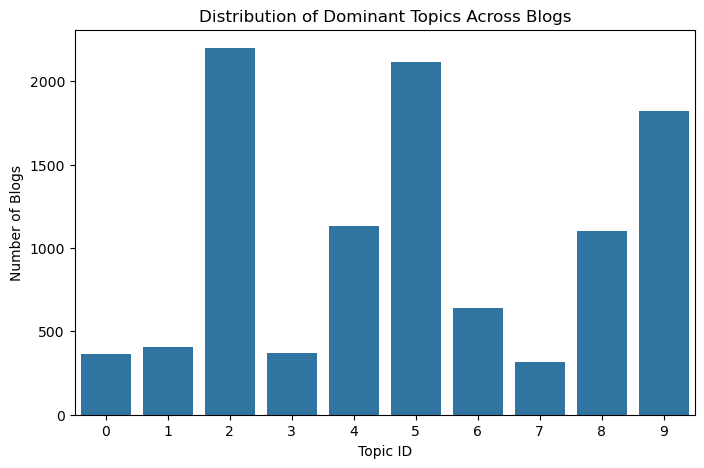

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=blogs_df, x='topic_id')
plt.title("Distribution of Dominant Topics Across Blogs")
plt.xlabel("Topic ID")
plt.ylabel("Number of Blogs")
plt.show()
